In [ ]:
# default_exp models.aft

# Accelerated Failure Time Models
> AFT Model theory.

We can model the time to failure as:
$$
\log T_i = \mu + \xi_i
$$
where $\xi_i\sim p(\xi|\theta)$ and $\mu$ is the most likely log time of death (the mode of the distribution of $T_i$). We model log death as that way we do not need to restrict $\mu + \xi_i$ to be positive.

In the censored case, where $t_i$ is the time where an instance was censored, and $T_i$ is the unobserved time of death, we have:
$$
\begin{aligned}
\log T_i &= \mu(x_i) + \xi_i > \log t_i\\
\therefore \xi_i &> \log t_i - \mu(x_i)
\end{aligned}
$$
Note that $\mu$ is a function of the features $x$. The log likelihood of the data ($\mathcal{D}$) can then shown to be:
$$
\begin{aligned}
\log p(\mathcal{D}) = \sum_{i=1}^N \mathcal{1}(y_i=1)\log p(\xi_i = \log t_i - \mu(x_i)) + \mathcal{1}(y_i=0)\log p(\xi_i &> \log t_i - \mu(x_i))
\end{aligned}
$$

In [ ]:
#export
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

from torchlife.models.error_dist import get_distribution

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
# export
class AFTModel(nn.Module):
    """
    Accelerated Failure Time model
    parameters:
    - Distribution of which the error is assumed to be
    - t_scaler: time scaling sklearn object
    - x_scaler (optional): feature scaler
    - dim (optional): input dimensionality of variables
    - h (optional): number of hidden nodes
    """
    def __init__(self, distribution:str, 
                 t_scaler:MaxAbsScaler, x_scaler:StandardScaler=None, 
                 dim:int=0, h:tuple=()):
        super().__init__()
        self.logpdf, self.logcdf = get_distribution(distribution)
        self.β = nn.Parameter(-torch.rand(1))
        self.logσ = nn.Parameter(-torch.rand(1))
        if dim > 0:
            nodes = (dim,) + h + (1,)
            self.layers = nn.ModuleList([nn.Linear(a,b, bias=False) 
                                       for a,b in zip(nodes[:-1], nodes[1:])])

        self.t_scaler, self.x_scaler = t_scaler, x_scaler
        self.eps = 1e-7

    def forward(self, t:torch.Tensor, x:torch.Tensor=None):
        # get the Kaplan Meier estimates
        μ = self.β
        if x:
            for layer in self.layers[:-1]:
                x = F.relu(layer(x))
            μ += self.layers[-1](x)

        ξ = torch.log(t + self.eps) - μ
        σ = torch.exp(self.logσ)
        logpdf = self.logpdf(ξ, σ)
        logcdf = self.logcdf(ξ, σ)
        return logpdf, logcdf
    
    def survival_function(self, t:np.array, x:np.array=None):
        if len(t.shape) == 1:
            t = t[:,None]
        t = self.t_scaler.transform(t)
        t = torch.Tensor(t)
        if x is not None:
            if len(x.shape) == 1:
                x = x[None, :]
            if len(x) == 1:
                x = np.repeat(x, len(t), axis=0)
            x = self.x_scaler.transform(x)
            x = torch.Tensor(x)
        
        with torch.no_grad():
            # calculate cumulative hazard according to above
            _, Λ = self.forward(t, x)
            return torch.exp(Λ)
            
    def plot_survival_function(self, t:np.array, x:np.array=None):
        surv_fun = self.survival_function(t, x)
        
        # plot
        plt.figure(figsize=(12,5))
        plt.plot(t, surv_fun)
        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.show()

Modelling based on **only** time and (death) event variables:

In [ ]:
from torchlife.data import create_db
import pandas as pd

url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/survival/flchain.csv"
df = pd.read_csv(url).iloc[:,1:]
df.rename(columns={'futime':'t', 'death':'e'}, inplace=True)

db, t_scaler, x_scaler = create_db(df[['t', 'e']])

death_rate = 100*df["e"].mean()
print(f"Death occurs in {death_rate:.2f}% of cases")
print(df.shape)
df.head()

Death occurs in 27.55% of cases
(7874, 11)


,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,t,e,chapter
0,97,F,1997,5.70,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.87,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.36,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.42,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.32,1.690,6,1.1,0,1039,1,Circulatory


epoch,train_loss,valid_loss,time
0,2.303370,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


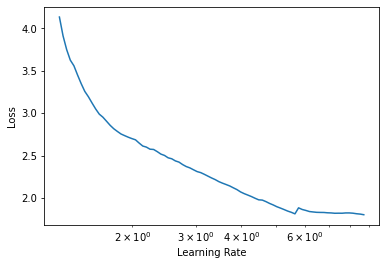

In [ ]:
# hide
from fastai.basics import Learner
from torchlife.losses import aft_loss

model = AFTModel("Gumbel", t_scaler, x_scaler)
learner = Learner(db, model, loss_func=aft_loss)
# wd = 1e-4
learner.lr_find(start_lr=1, end_lr=10)
learner.recorder.plot()

In [ ]:
learner.fit(epochs=10, lr=2)

epoch,train_loss,valid_loss,time
0,19.762524,0.835701,00:00
1,6.534316,0.765715,00:00
2,3.093488,0.692992,00:00
3,2.217175,0.616735,00:00
4,1.901152,0.594021,00:00
5,1.992485,0.630431,00:00
6,1.497912,0.572270,00:00
7,1.416025,0.567332,00:00
8,1.382292,0.570403,00:00
9,1.371018,0.570522,00:00


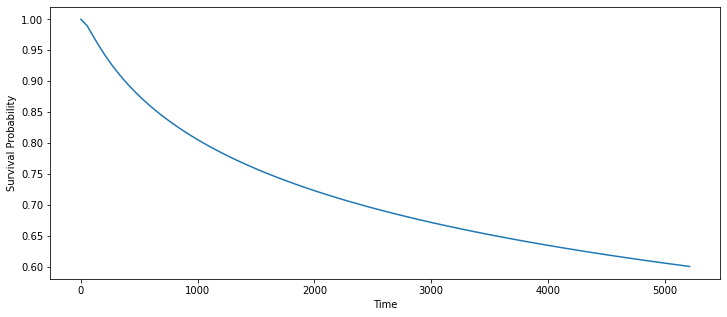

In [ ]:
model.plot_survival_function(np.linspace(0, df["t"].max(), 100))

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_index.ipynb.
Converted 10_SAT.ipynb.
Converted 20_KaplanMeier.ipynb.
Converted 50_hazard.ipynb.
Converted 55_hazard.PiecewiseHazard.ipynb.
Converted 59_hazard.Cox.ipynb.
Converted 60_AFT_models.ipynb.
Converted 65_AFT_error_distributions.ipynb.
Converted 80_data.ipynb.
Converted 90_model.ipynb.
Converted 95_Losses.ipynb.
